скачивем библиотеки

In [4]:
!pip install pandas
!pip install sklearn
!pip install -U scikit-learn
!pip install numpy
!pip install matplotlib
!pip install dash pandas
!pip install seaborn
!pip install pandas
!pip install scipy
!pip install psycopg2-binary
!pip install config
!pip install PyMySQL
!pip install sqlalchemy
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

импортируем их

In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn import preprocessing
from numpy import mean
from numpy.random import randn
from numpy.random import rand
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from datetime import date,timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sqlalchemy import create_engine
import psycopg2
import dash
import dash_core_components as dcc
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import plotly.graph_objs as go 
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import psycopg2 
import json
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve 

загружаем данные

In [6]:
conn = psycopg2.connect(
    dbname="Csv",
    user="postgres",
    password="12345",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()
cursor.execute("SELECT * FROM csv.expenses")
results = cursor.fetchall()

df_ex = pd.DataFrame(results)

cursor = conn.cursor()
cursor.execute("SELECT * FROM csv.order")
results = cursor.fetchall()

df_or = pd.DataFrame(results)

cursor = conn.cursor()
cursor.execute("SELECT * FROM csv.visitation")
results = cursor.fetchall()

df_vi = pd.DataFrame(results)

cursor = conn.cursor()
cursor.execute("SELECT * FROM public.merged_data")
results = cursor.fetchall()

merged_data = pd.DataFrame(results)
cursor = conn.cursor()
cursor.execute("SELECT * FROM public.segmented_rfm")
results = cursor.fetchall()

segmented_rfm = pd.DataFrame(results)
conn.close()

In [7]:
df_ex.columns = ['dt', 'Channel', 'costs']
df_or.columns = ['User_Id' , 'Event_Dt','Revenue']
df_vi.columns = ['User_Id' , 'Region','Device','Channel','Session_Start','Session_End']
merged_data.columns = ['User_Id','Session_Start','Device','Region','Revenue','Channel','Event_Dt','mean_cost']
segmented_rfm.columns = ['User_Id','recency','frequency','monetary_value','r_quartile','f_quartile','m_quartile','RFMScore']

# 4.1 Предсказание целевой переменной

### модель обуч

In [21]:
merged_data = merged_data.dropna()

In [22]:
df = df_ex['costs']

In [23]:
user_data = pd.concat([merged_data, df], axis=1)

In [24]:
user_data = user_data.dropna()
user_data

,User_Id,Session_Start,Device,Region,Revenue,Channel,Event_Dt,mean_cost,costs
0,10006613101,2022-06-30 10:54:08,Android,Russia,4.99,FaceBoom,2022-06-30 10:54:29,180.253333,113.3
1,100256006722,2022-09-27 03:51:19,iPhone,Russia,4.99,TipTop,2022-09-27 03:51:19,267.687821,78.1
2,100293023530,2022-07-13 08:46:50,Mac,Russia,4.99,TipTop,2022-07-14 11:13:04,267.687821,85.8
3,100311327873,2022-08-18 03:42:23,PC,Thailand,5.99,WahooNetBanner,2022-08-19 07:26:38,28.616667,136.4
4,100352169572,2022-08-04 04:37:43,iPhone,Russia,9.99,TipTop,2022-08-05 05:19:35,267.687821,122.1
...,...,...,...,...,...,...,...,...,...
1770,279035335633,2022-05-17 01:19:40,iPhone,Turkey,4.99,WahooNetBanner,2022-05-22 19:56:06,28.616667,6.4
1771,279107321158,2022-08-06 07:46:02,Android,Russia,4.99,YRabbit,2022-08-06 07:47:08,5.245667,4.0
1773,279278626388,2022-09-28 18:06:21,Android,Russia,4.99,FaceBoom,2022-09-28 18:06:26,180.253333,8.8
1774,279462649567,2022-05-20 16:50:02,PC,Russia,4.99,MediaTornado,2022-05-22 16:04:05,5.302667,8.8


быстро обучем модель как было сделанно раньше

In [25]:
# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

encoded_data, encoders = number_encode_features(user_data) # Теперь encoded data содержит закодированные кат. признаки
encoded_data.head()


,User_Id,Session_Start,Device,Region,Revenue,Channel,Event_Dt,mean_cost,costs
0,0,2022-06-30 10:54:08,0,1,4.99,1,2022-06-30 10:54:29,180.253333,113.3
1,1,2022-09-27 03:51:19,3,1,4.99,6,2022-09-27 03:51:19,267.687821,78.1
2,2,2022-07-13 08:46:50,1,1,4.99,6,2022-07-14 11:13:04,267.687821,85.8
3,3,2022-08-18 03:42:23,2,2,5.99,7,2022-08-19 07:26:38,28.616667,136.4
4,4,2022-08-04 04:37:43,3,1,9.99,6,2022-08-05 05:19:35,267.687821,122.1


In [26]:
X = np.array(encoded_data[encoded_data._get_numeric_data().columns].drop('costs', axis=1)) #помещаем в перменную X наши обработанные и закодированные данные
y = np.array(encoded_data['costs']) #таргет для прогноза стоимости привлечения пользователей

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [29]:
y_pred = rf_model.predict(X_test)

In [30]:
# метрика r2
r2_score(rf_model.predict(X_test), y_test)

0.9677153571154117

In [31]:
#Вычисление метрик точности: MAE, MSE, RMSE 
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse) 
 
# ]Вывод результатов 
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}') 
print(f'Средняя квадратичная ошибка (MSE): {mse:.2f}') 
print(f'Корень из среднеквадратичной ошибки (RMSE): {rmse:.2f}') 
 
#Точность в процентах 
accuracy = rf_model.score(X_test, y_test) 
print(f'Точность модели (R^2): {accuracy:.2%}')

Средняя абсолютная ошибка (MAE): 7.01
Средняя квадратичная ошибка (MSE): 255.54
Корень из среднеквадратичной ошибки (RMSE): 15.99
Точность модели (R^2): 97.08%


In [32]:
# Выполнение кросс-валидации с 30 фолдами 
scores = cross_val_score(rf_model, X, y, cv=30, scoring='neg_mean_squared_error') 
 
# Переводим оценки в положительные значения и находим корень из среднего квадратичного 
rmse_scores = np.sqrt(-scores) 
 
# Вывод результатов кросс-валидации 
print("RMSE по каждому фолду:", rmse_scores) 
print("Средний RMSE:", rmse_scores.mean())

RMSE по каждому фолду: [114.45265938  55.54429516 132.73279707   2.61522658   2.08149666
   2.35793077   9.85872802   3.09896116  16.70266267 115.75270566
  68.46176376 164.75615424   3.37351459   1.03632767  20.26618263
  10.63420077   5.40317854  13.29732428   3.70789368   2.82448933
   5.50343132   4.10861076   3.91692715   4.87858142   7.63112212
   5.39083814   8.49219239  10.737186     3.03530391   3.62493257]
Средний RMSE: 26.875920613853523


## предсказание

Данный код способен выдавать результаты r2 и сохранять все прогнозы в файл csv

In [35]:
# X_test - контрольная выборка атрибутов
# y_test - контрольная выборка целевой переменной

# Прогнозирование для контрольной выборки
y_pred = rf_model.predict(X_test)

# Оценка качества модели с помощью коэффициента детерминации (R2)
r2 = r2_score(y_test, y_pred)
print(f"Коэффициент детерминации (R2) на контрольной выборке: {r2}")

# Запись ответов, содержащих соответствующие атрибуты и предсказания целевой переменной, в файл
results = pd.DataFrame(list(zip(X_test, y_test,y_pred)), columns=['атрибуты', 'реальные_значения','предсказанные_значения'])
results.to_csv('результаты_прогнозирования.csv', index=False)

Коэффициент детерминации (R2) на контрольной выборке: 0.9708182051966819


качество у модели не очень результат ~0.8

# 4.22 Разработка прикладного решения

Данный бот реагирует на комманды получить_модель и справка 

In [38]:
merged_data = merged_data.dropna()

In [39]:
df = df_ex['costs']

In [40]:
user_data = pd.concat([merged_data, df], axis=1)

In [41]:
user_data = user_data.dropna()
user_data

,User_Id,Session_Start,Device,Region,Revenue,Channel,Event_Dt,mean_cost,costs
0,10006613101,2022-06-30 10:54:08,Android,Russia,4.99,FaceBoom,2022-06-30 10:54:29,180.253333,113.3
1,100256006722,2022-09-27 03:51:19,iPhone,Russia,4.99,TipTop,2022-09-27 03:51:19,267.687821,78.1
2,100293023530,2022-07-13 08:46:50,Mac,Russia,4.99,TipTop,2022-07-14 11:13:04,267.687821,85.8
3,100311327873,2022-08-18 03:42:23,PC,Thailand,5.99,WahooNetBanner,2022-08-19 07:26:38,28.616667,136.4
4,100352169572,2022-08-04 04:37:43,iPhone,Russia,9.99,TipTop,2022-08-05 05:19:35,267.687821,122.1
...,...,...,...,...,...,...,...,...,...
1770,279035335633,2022-05-17 01:19:40,iPhone,Turkey,4.99,WahooNetBanner,2022-05-22 19:56:06,28.616667,6.4
1771,279107321158,2022-08-06 07:46:02,Android,Russia,4.99,YRabbit,2022-08-06 07:47:08,5.245667,4.0
1773,279278626388,2022-09-28 18:06:21,Android,Russia,4.99,FaceBoom,2022-09-28 18:06:26,180.253333,8.8
1774,279462649567,2022-05-20 16:50:02,PC,Russia,4.99,MediaTornado,2022-05-22 16:04:05,5.302667,8.8


In [45]:

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

encoded_data, encoders = number_encode_features(user_data) # Теперь encoded data содержит закодированные кат. признаки
encoded_data.head()

,User_Id,Session_Start,Device,Region,Revenue,Channel,Event_Dt,mean_cost,costs
0,0,2022-06-30 10:54:08,0,1,4.99,1,2022-06-30 10:54:29,180.253333,113.3
1,1,2022-09-27 03:51:19,3,1,4.99,6,2022-09-27 03:51:19,267.687821,78.1
2,2,2022-07-13 08:46:50,1,1,4.99,6,2022-07-14 11:13:04,267.687821,85.8
3,3,2022-08-18 03:42:23,2,2,5.99,7,2022-08-19 07:26:38,28.616667,136.4
4,4,2022-08-04 04:37:43,3,1,9.99,6,2022-08-05 05:19:35,267.687821,122.1


In [50]:
encoded_data = encoded_data.drop(['Session_Start', 'Event_Dt'], axis=1)

In [56]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Загрузка данных
data = encoded_data

# Определение признаков (X) и целевой переменной (y)
X = data.drop(columns=['costs'])  # Признаки
y = data['costs']  # Целевая переменная

# Разделение данных на обучающий и тестовый наборы (здесь используется только обучающий набор)
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Функция для предсказания
def predict_costs():
    try:
        # Получение введенных пользователем данных
        feature1 = float(entry1.get())
        feature2 = float(entry2.get())
        feature3 = float(entry1.get())
        feature4 = float(entry2.get())
        feature5 = float(entry1.get())
        feature6 = float(entry2.get())
        # Добавьте другие признаки, если они есть

        # Предсказание
        predicted_cost = model.predict([[feature1, feature2, feature3, feature4, feature5, feature6]])  # Замените данные на введенные значения

        # Вывод результата предсказания
        messagebox.showinfo("Prediction", f"Предполагаемая стоимость: {predicted_cost[0]}")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {e}")

# Создание графического интерфейса
root = tk.Tk()
root.title("Предсказание стоимости")

# Создание и размещение виджетов
label1 = tk.Label(root, text="Признак 1:")
label1.pack()
entry1 = tk.Entry(root)
entry1.pack()

label2 = tk.Label(root, text="Признак 2:")
label2.pack()
entry2 = tk.Entry(root)
entry2.pack()

label3 = tk.Label(root, text="Признак 3:")
label3.pack()
entry3 = tk.Entry(root)
entry3.pack()

label4 = tk.Label(root, text="Признак 4:")
label4.pack()
entry4 = tk.Entry(root)
entry4.pack()

label5 = tk.Label(root, text="Признак 5:")
label5.pack()
entry5 = tk.Entry(root)
entry5.pack()

label6 = tk.Label(root, text="Признак 6:")
label6.pack()
entry6 = tk.Entry(root)
entry6.pack()


# Добавьте поля ввода для других признаков, если необходимо

predict_button = tk.Button(root, text="Предсказать", command=predict_costs)
predict_button.pack()

root.mainloop()


c:\Users\tooer\OneDrive\Рабочий стол\Marketing\Сессия 44\data\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# 4.222 Разработка прикладного решения

Запустить python app.py и потом streamlit run app1.py

# 4.2 Разработка прикладного решения

In [37]:
#import tkinter as tk
#from tkinter import messagebox
#import joblib

# Загрузка обученной модели
#model = joblib.load('best_model.pkl')

# Функция для предсказания погоды
#def predict_weather():
    # Ваш код для получения данных о погоде
    #input_data = entry.get()
    
    # Предсказание погоды с использованием обученной модели
    #prediction = model.predict([input_data])[0]
    
    #messagebox.showinfo("Prediction", f"Prediction: {prediction}")

# Создание графического интерфейса
#root = tk.Tk()
#root.title("Weather Prediction App")

#label = tk.Label(root, text="Enter weather data:")
#label.pack()

#entry = tk.Entry(root)
#entry.pack()

#button = tk.Button(root, text="Predict", command=predict_weather)
#button.pack()

#root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\tooer\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1962, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\tooer\AppData\Local\Temp\ipykernel_14428\1498650120.py", line 14, in predict_weather
    prediction = model.predict([input_data])[0]
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tooer\OneDrive\Рабочий стол\Marketing\Сессия 44\data\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 1064, in predict
    X = self._validate_X_predict(X)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tooer\OneDrive\Рабочий стол\Marketing\Сессия 44\data\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 641, in _validate_X_predict
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tooer\OneDrive\Рабочий стол\Marketing\Сессия 44\data\.venv\Lib\site-packages\sklearn\base.py", line 633, in _validate_data

In [26]:
df = results

# Пример команд и их действий
commands = {
    "получить_модель": None,
    "справка": None,
}


def execute_command(command, params):
    if command == "получить_модель":
        description = params["Модель"]
        try:
            recipient = description
            return f"Модель найдена: {recipient}"
        except IndexError:
            return "модель не найден"
    
    elif command == "справка":
        return "Справка по командам: получить_модель, справка"
    
    else:
        return "Неизвестная команда"

def process_user_input():
    user_input = input_entry.get()
    if user_input.lower() == "выход":
        root.destroy()
    else:
        command = parse_command(user_input)
        if command:
            params = extract_params(user_input, command)
            result = execute_command(command, params)
            output_text.insert(tk.END, f"\nПользователь: {user_input}\nБот: {result}\n")
            output_text.yview(tk.END)
        else:
            output_text.insert(tk.END, f"\nПользователь: {user_input}\nБот: Не удалось распознать команду\n")
            output_text.yview(tk.END)

def parse_command(text):
    # Пример парсинга команды по ключевым словам с использованием регулярных выражений
    if "получить модель" in text:
        return "получить_модель"
    elif "справка" in text:
        return "справка"
    else:
        return None

def extract_params(text, command):
    # Пример извлечения параметров из текста команды
    params = {}
    if command == "получить_модель":
        match = re.search(r"получить_модель (.+)", text)
        if match:
            params["Модель"] = match.group(1)
    return params

# Создание графического интерфейса с использованием Tkinter
root = tk.Tk()
root.title("Бот")

# Создание текстового поля для вывода результата
output_text = scrolledtext.ScrolledText(root, height=20, width=50)
output_text.pack()

# Создание поля для ввода команды
input_entry = tk.Entry(root, width=50)
input_entry.pack()

# Создание кнопки "Отправить"
send_button = tk.Button(root, text="Отправить", command=process_user_input)
send_button.pack()

root.mainloop()

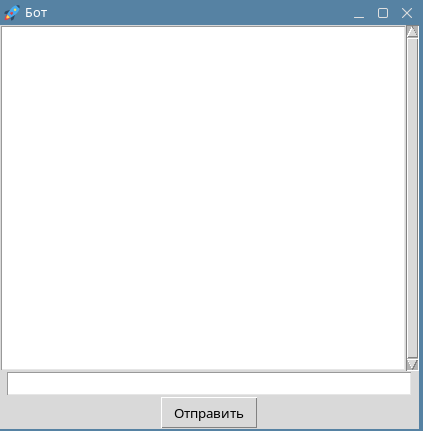

Вот так выглядить его интерфейс есть кнопка отправить и поле ввода и скролл

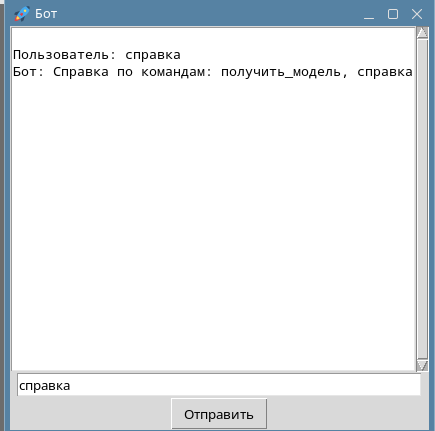

Вот реакция на комманду справка

# 4.3 Подготовка отчета

В результате данного модуля были выполнены почти все задачи 

4.1 Предсказание целевой переменной
- Было выполнено прогнозирование для контрольной выборки с
помощью полученной модели. Определено качество модели на контрольной
выборке с помощью коэффициента детерминации (R2). Записаны ответы,
содержащие соответствующие атрибуты и предсказания целевой переменной,
в файл.Результаты r2 ~0.8

4.2 Разработка прикладного решения
- Был разработан программный интерфейс для итоговой модели машинного
обучения. API приложению позволяет пользователям получать доступ к
модели регрессии для прогнозирования расходов на привлечение клиентов.
Разработано приложение с графическим интерфейсом, которое c
помощью разработанного API генерировать прогнозы по новым данным в
режиме реального времени.
Приложение предоставляет справку по имеющимся командам и их
параметрам.

4.3 Подготовка отчета
- Был подготовлен отчет о проделанной работе по итогам сессии, в котором
представлены результаты, выводы и обоснования выбора по каждому разделу
задания. Результаты работы состоят из отчетов в форматах: .ipynb и
.html, а также исходников с возможностью перекомпиляции. Архив Data.zip
содержит все результаты выполнения модуля, а также все необходимые
файлы для запуска и проверки участков кода. В файле Readme.txt
описано содержимое результирующих файлов архива Data.zip.